In [10]:
!pip install bokeh
!pip install celluloid
from celluloid import Camera

In [11]:
import collections
import itertools
import math

import numpy as np
np.seterr(divide='ignore')
import numpy.random as rnd
import networkx as nx

import param
import holoviews as hv
import bokeh.io
from matplotlib import animation
import matplotlib as plt
import matplotlib_inline
from matplotlib import rc

In [ ]:
bokeh.io.output_notebook()

In [12]:
hv.extension('bokeh', 'matplotlib')

Output hidden; open in https://colab.research.google.com to view.

In [14]:


# Set colors and style options for the Element types
from holoviews import Store, Options
opts = Store.options()

colormap = {k: v for k, v in zip('SVIRD', hv.Cycle().values)}

opts.Graph     = Options('plot', color_index='State')
opts.Graph     = Options('style', cmap=colormap, node_size=6, edge_line_width=1)
opts.Histogram = Options('plot', show_grid=False)
opts.Overlay   = Options('plot', show_frame=False)
opts.HeatMap   = Options('plot', xrotation=90)
opts.ItemTable = Options('plot', width=900, height=50)

opts.Overlay.Network = Options('plot', xaxis=None, yaxis=None)
opts.Overlay.Counts  = Options('plot', show_grid=True)

opts.VLine     = {'style': Options(color='black', line_width=1),
                  'plot':  Options(show_grid=True)}

In [15]:
class SRI_Model(param.Parameterized):
    """
    Implementation of the SRI epidemiology model
    using NetworkX and HoloViews for visualization.
    This code has been adapted from Simon Dobson's
    code here:
    
    http://www.simondobson.org/complex-networks-complex-processes/epidemic-spreading.html
    
    In addition to his basic parameters I've added
    additional states to the model, a node may be
    in one of the following states:
    
      * Susceptible: Can catch the disease from a connected node.
      * Vaccinated: Immune to infection.
      * Infected: Has the disease and may pass it on to any connected node.
      * Recovered: Immune to infection.
      * Dead: Edges are removed from graph.
    """

    network = param.ClassSelector(class_=nx.Graph, default=None, doc="""
        A custom NetworkX graph, instead of the default Erdos-Renyi graph.""")
    
    visualize = param.Boolean(default=True, doc="""
        Whether to compute layout of network for visualization.""")
    
    N = param.Integer(default=1000, doc="""
        Number of nodes to simulate.""")
    
    mean_connections = param.Number(default=10, doc="""
        Mean number of connections to make to other nodes.""")
    
    pSick = param.Number(default=0.01, doc="""
        Probability of a node to be initialized in sick state.""", bounds=(0, 1))

    pVaccinated = param.Number(default=0.1, bounds=(0, 1), doc="""
        Probability of a node to be initialized in vaccinated state.""")
    
    pInfect = param.Number(default=0.3, doc="""
        Probability of infection on each time step.""", bounds=(0, 1))
    
    pRecover = param.Number(default=0.05, doc="""
        Probability of recovering if infected on each timestep.""", bounds=(0, 1))
    
    pDeath = param.Number(default=0.1, doc="""
        Probability of death if infected on each timestep.""", bounds=(0, 1))
    
    
    SPREADING_SUSCEPTIBLE = 'S'
    SPREADING_VACCINATED = 'V'
    SPREADING_INFECTED = 'I'
    SPREADING_RECOVERED = 'R'
    DEAD = 'D'

    def __init__(self, **params):
        super(SRI_Model, self).__init__(**params)
        if not self.network:
            self.g = nx.erdos_renyi_graph(self.N, float(self.mean_connections)/self.N)
        else:
            self.g = self.network
        self.vaccinated, self.infected = self.spreading_init()
        self.model = self.spreading_make_sir_model()
        self.color_mapping = [self.SPREADING_SUSCEPTIBLE,
                              self.SPREADING_VACCINATED,
                              self.SPREADING_INFECTED,
                              self.SPREADING_RECOVERED, self.DEAD]
        if self.visualize:
            k = 2/(math.sqrt(self.g.order()))
            self.pos = hv.Graph.from_networkx(self.g, nx.spring_layout, iterations=50, k=k)

    def spreading_init(self):
        """Initialise the network with vaccinated, susceptible and infected states."""
        vaccinated, infected = 0, []
        for i in self.g.nodes.keys():
            self.g.nodes[i]['transmissions'] = 0
            if(rnd.random() <= self.pVaccinated): 
                self.g.nodes[i]['state'] = self.SPREADING_VACCINATED
                vaccinated += 1
            elif(rnd.random() <= self.pSick):
                self.g.nodes[i]['state'] = self.SPREADING_INFECTED
                infected.append(i)
            else:
                self.g.nodes[i]['state'] = self.SPREADING_SUSCEPTIBLE
        return vaccinated, infected

    def spreading_make_sir_model(self):
        """Return an SIR model function for given infection and recovery probabilities."""
        # model (local rule) function
        def model( g, i ):
            if g.nodes[i]['state'] == self.SPREADING_INFECTED:
                # infect susceptible neighbours with probability pInfect
                for m in g.neighbors(i):
                    if g.nodes[m]['state'] == self.SPREADING_SUSCEPTIBLE:
                        if rnd.random() <= self.pInfect:
                            g.nodes[m]['state'] = self.SPREADING_INFECTED
                            self.infected.append(m)
                            g.nodes[i]['transmissions'] += 1

                # recover with probability pRecover
                if rnd.random() <= self.pRecover:
                    g.nodes[i]['state'] = self.SPREADING_RECOVERED
                elif rnd.random() <= self.pDeath:
                    edges = [edge for edge in self.g.edges() if i in edge] 
                    g.nodes[i]['state'] = self.DEAD
                    g.remove_edges_from(edges)

        return model

    def step(self):
        """Run a single step of the model over the graph."""
        for i in self.g.nodes.keys():
            self.model(self.g, i)

    def run(self, steps):
        """
        Run the network for the specified number of time steps
        """
        for i in range(steps):
            self.step()

    def stats(self):
        """
        Return an ItemTable with statistics on the network data.
        """
        state_labels = hv.OrderedDict([('S', 'Susceptible'), ('V', 'Vaccinated'), ('I', 'Infected'),
                                       ('R', 'Recovered'), ('D', 'Dead')])
        counts = collections.Counter()
        transmissions = []
        for n in self.g.nodes():
            state = state_labels[self.g.nodes[n]['state']]
            counts[state] += 1
            if n in self.infected:
                transmissions.append(self.g.nodes[n]['transmissions'])
        data = hv.OrderedDict([(l, counts[l])
                               for l in state_labels.values()])
        
        infected = len(set(self.infected))
        unvaccinated = float(self.N-self.vaccinated)
        
        data['$R_0$'] = np.mean(transmissions) if transmissions else 0
        data['Death rate DR'] = np.divide(float(data['Dead']),self.N)
        data['Infection rate IR'] = np.divide(float(infected), self.N)
        if unvaccinated:
            unvaccinated_dr = data['Dead']/unvaccinated
            unvaccinated_ir = infected/unvaccinated
        else:
            unvaccinated_dr = 0
            unvaccinated_ir = 0
        data['Unvaccinated DR'] = unvaccinated_dr
        data['Unvaccinated IR'] = unvaccinated_ir
        return hv.ItemTable(data)

    def animate(self, steps):
        """
        Run the network for the specified number of steps accumulating animations
        of the network nodes and edges changing states and curves tracking the
        spread of the disease.
        """
        if not self.visualize:
            raise Exception("Enable visualize option to get compute network visulizations.")

        # Declare HoloMap for network animation and counts array
        network_hmap = hv.HoloMap(kdims='Time')
        sird = np.zeros((steps, 5))
        
        # Declare labels
        state_labels = ['Susceptible', 'Vaccinated', 'Infected', 'Recovered', 'Dead']

        # Text annotation
        nlabel = hv.Text(0.9, 0.05, 'N=%d' % self.N)

        for i in range(steps):
            # Get path, point, states and count data
            states = [self.g.nodes[n]['state'] for n in self.g.nodes()]
            state_ints = [self.color_mapping.index(v) for v in states]
            state_array = np.array(state_ints, ndmin=2).T
            (sird[i, :], _) = np.histogram(state_array, bins=list(range(6)))

            # Create network path and node Elements
            nodes = self.pos.nodes.clone(datatype=['dictionary'])
            nodes = nodes.add_dimension('State', 0, states, True)
            graph = self.pos.clone((self.pos.data.copy(), nodes))
            # Create overlay and accumulate in network HoloMap
            network_hmap[i] = (graph * nlabel).relabel(group='Network', label='SRI')
            self.step()

        # Create Overlay of Curves
        #extents = (-1, -1, steps, np.max(sird)+2)
        curves = hv.NdOverlay({label: hv.Curve(zip(range(steps), sird[:, i]),
                                               'Time', 'Count')
                              for i, label in enumerate(state_labels)},
                              kdims=[hv.Dimension('State', values=state_labels)])
        
        # Animate VLine on top of Curves
        distribution = hv.HoloMap({i: (curves * hv.VLine(i)).relabel(group='Counts', label='SRI')
                                   for i in range(steps)}, kdims='Time')
        
        return network_hmap + distribution

In [16]:
experiment1_params = dict(pInfect=0.08, pRecover=0.08, pSick=0.15,
                          N=50, mean_connections=10, pDeath=0.1)

In [20]:
sri_model = SRI_Model(pVaccinated=0.1, **experiment1_params)
sri_model.animate(21).redim.range(x=(-1.2, 1.2), y=(-1.2, 1.2))

:Layout
   .Network.SRI :HoloMap   [Time]
      :Overlay
         .Graph.I :Graph   [start,end]
         .Text.I  :Text   [x,y]
   .Counts.SRI  :HoloMap   [Time]
      :Overlay
         .NdOverlay.I :NdOverlay   [State]
            :Curve   [Time]   (Count)
         .VLine.I     :VLine   [x,y]

In [ ]:
x = sri_model.animate(2).redim.range(x=(-1.2, 1.2), y=(-1.2, 1.2))

In [ ]:
sri_model.stats().opts(hv.opts.ItemTable(width=900, height=50))

AttributeError: ignored

In [ ]:
sri_model = SRI_Model(pVaccinated=0.65, **experiment1_params)
sri_model.animate(21)

:Layout
   .Network.SRI :HoloMap   [Time]
      :Overlay
         .Graph.I :Graph   [start,end]
         .Text.I  :Text   [x,y]
   .Counts.SRI  :HoloMap   [Time]
      :Overlay
         .NdOverlay.I :NdOverlay   [State]
            :Curve   [Time]   (Count)
         .VLine.I     :VLine   [x,y]

In [ ]:
hv.output(holomap='scrubber', size=150)
sri_model_lv = SRI_Model(pVaccinated=0.1, **dict(experiment1_params, N=1000))
sri_layout = sri_model_lv.animate(31)
sri_layout.Network.SRI[::2]

:HoloMap   [Time]
   :Overlay
      .Graph.I :Graph   [start,end]
      .Text.I  :Text   [x,y]

In [ ]:
sri_layout.Network.SRI[::2]

:HoloMap   [Time]
   :Overlay
      .Graph.I :Graph   [start,end]
      .Text.I  :Text   [x,y]

In [ ]:
sri_model_hv = SRI_Model(pVaccinated=0.65, visualize=False, **dict(experiment1_params, N=1000))
sri_model_hv.run(100)
(sri_model_lv.stats().relabel('Low Vaccination Population') +
 sri_model_hv.stats().relabel('High Vaccination Population')).cols(1)

:Layout
   .ItemTable.Low_Vaccination_Population  :ItemTable   (Susceptible,Vaccinated,Infected,Recovered,Dead,$R_0$,Death rate DR,Infection rate IR,Unvaccinated DR,Unvaccinated IR)
   .ItemTable.High_Vaccination_Population :ItemTable   (Susceptible,Vaccinated,Infected,Recovered,Dead,$R_0$,Death rate DR,Infection rate IR,Unvaccinated DR,Unvaccinated IR)

In [ ]:
experiment2_params = dict(N=1000, pInfect=0.05, pRecover=0.05,
                          pSick=0.05, pDeath=0.001, visualize=False)

In [ ]:
exp2_dims = ['Connections', 'pVaccinated']
hmap = hv.HoloMap(kdims=exp2_dims)
vacc_rates = np.linspace(0, 1, 21)
mean_conns = [2**i for i in range(7)]
for v, c in itertools.product(vacc_rates, mean_conns):
    sri_model = SRI_Model(mean_connections=c, pVaccinated=v, **experiment2_params)
    sri_model.run(100)
    hmap[c, v] = sri_model.stats()
df = hmap.dframe()

In [ ]:
df[::20]

,pVaccinated,Connections,Susceptible,Vaccinated,Infected,Recovered,Dead,$R_0$,Death rate DR,Infection rate IR,Unvaccinated DR,Unvaccinated IR
0,0.00,1,873,0,1,122,4,0.574803,0.004,0.127,0.004000,0.127000
0,1.00,1,0,1000,0,0,0,0.000000,0.000,0.000,0.000000,0.000000
0,0.95,2,37,960,0,3,0,0.000000,0.000,0.003,0.000000,0.075000
0,0.90,4,93,906,0,1,0,0.000000,0.000,0.001,0.000000,0.010638
0,0.85,8,140,851,0,9,0,0.000000,0.000,0.009,0.000000,0.060403
0,0.80,16,91,819,13,73,4,0.944444,0.004,0.090,0.022099,0.497238
0,0.75,32,6,760,2,226,6,0.952991,0.006,0.234,0.025000,0.975000
0,0.70,64,0,706,3,283,8,0.952381,0.008,0.294,0.027211,1.000000


In [ ]:
quantities = ['Unvaccinated IR', 'Infection rate IR', 'Death rate DR', '$R_0$']
state_labels = ['Susceptible', 'Vaccinated', 'Infected', 'Recovered', 'Dead']

hv.output(backend='matplotlib')

:Layout
   .R_0.I            :TriSurface   [pVaccinated,Connections]   ($R_0$)
   .Infection_Rate.I :TriSurface   [pVaccinated,Connections]   (Infection rate IR)
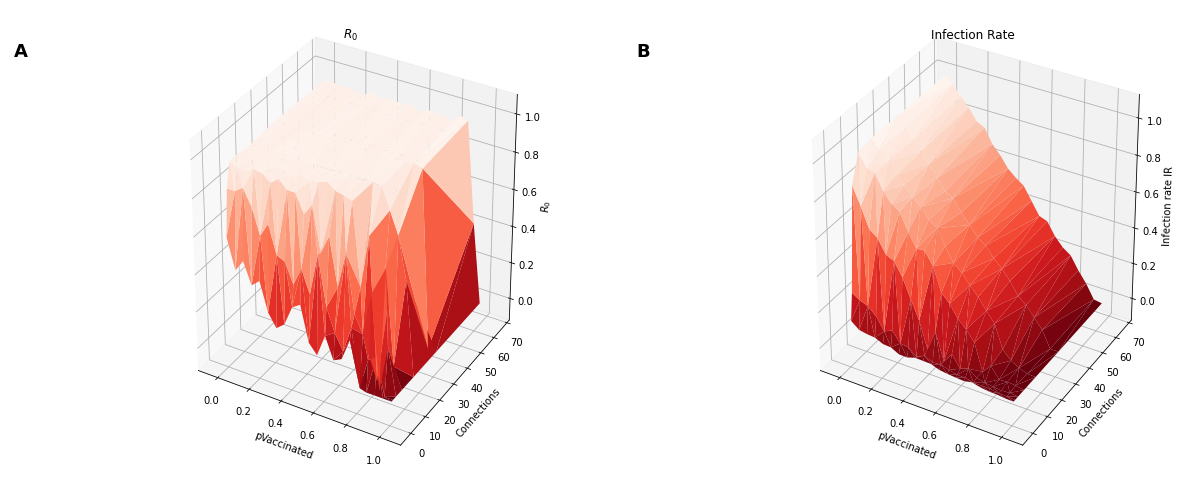

In [ ]:
hv.opts.defaults(
    hv.opts.Layout(fig_size=200),
    hv.opts.TriSurface(cmap='Reds_r', linewidth=0.1)
)
ds = hv.Dataset(df)
(ds.to.trisurface(['pVaccinated', 'Connections'], '$R_0$', [], group='$R_0$') +
 ds.to.trisurface(['pVaccinated', 'Connections'], 'Infection rate IR', [], group='Infection Rate'))

:Layout
   .Unvaccinated_IR.I   :AdjointLayout
      :HeatMap   [pVaccinated,Connections]   (Unvaccinated IR)
      :Histogram   [Unvaccinated IR]   (Unvaccinated IR_count)
   .Infection_rate_IR.I :AdjointLayout
      :HeatMap   [pVaccinated,Connections]   (Infection rate IR)
      :Histogram   [Infection rate IR]   (Infection rate IR_count)
   .Death_rate_DR.I     :AdjointLayout
      :HeatMap   [pVaccinated,Connections]   (Death rate DR)
      :Histogram   [Death rate DR]   (Death rate DR_count)
   .R_0.I               :AdjointLayout
      :HeatMap   [pVaccinated,Connections]   ($R_0$)
      :Histogram   [$R_0$]   ($R_0$_count)
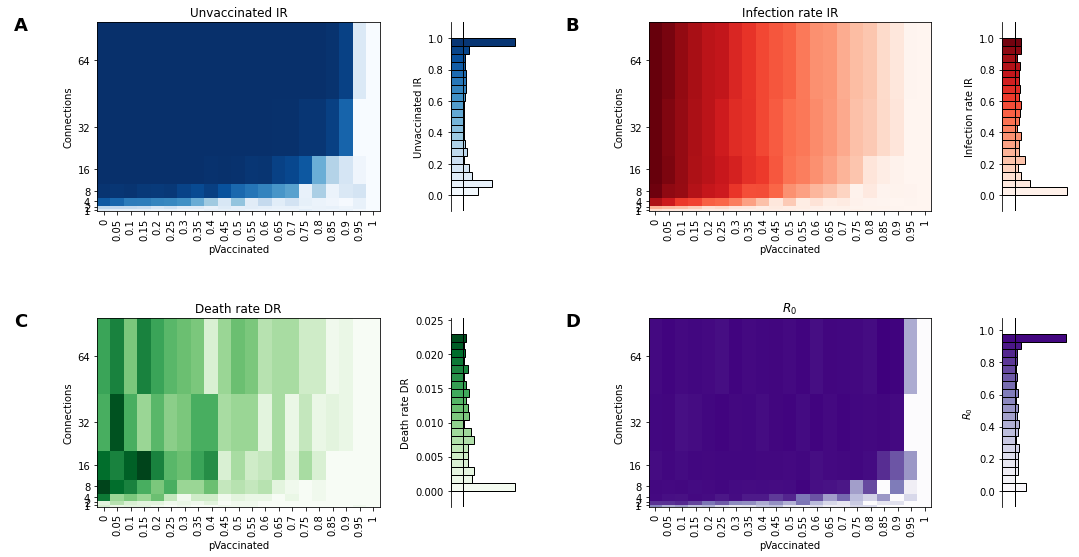

In [ ]:
hv.opts.defaults(
    hv.opts.HeatMap(show_values=False, aspect=1.5, xrotation=90),
    hv.opts.Histogram(axiswise=True),
    hv.opts.Layout(fig_size=150),
)
group_colors = zip(quantities, ['Blues', 'Reds', 'Greens', 'Purples'])
hv.Layout([hv.Table(df).to.heatmap(['pVaccinated', 'Connections'],
                                   q, [], group=q).opts(style=dict(cmap=c)).hist()
           for q, c in group_colors]).cols(2)

In [9]:
import holoviews as hv
hv.extension('bokeh')
h = hv.Curve([1,2,7], 'x_col', 'y_col')

from bokeh.io import show
from bokeh.models.tickers import FixedTicker

b = hv.render(h)
b.axis[0].ticker = FixedTicker(ticks=list(range(0, 10)))
show(b)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
import holoviews as hv
from bokeh.models.tickers import FixedTicker
hv.extension('bokeh')

def update_axis(plot, element):
    b = plot.state
    b.axis[0].ticker = FixedTicker(ticks=list(range(0, 10)))

h = hv.Curve([1,2,7], 'x_col', 'y_col')
h = h.opts(hooks=[update_axis])
h

Output hidden; open in https://colab.research.google.com to view.

In [19]:
from matplotlib import pyplot
pyplot.switch_backend('agg')